In [50]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#
# TODO: Parameters to play around with
PLOT_TYPE_TEXT = False # if you'd like to see indices
PLOT_VECTORS = True    # if you'd like to see your original features in P.C.-Space

matplotlib.style.use('ggplot') # Look Pretty
c = ['red', 'green', 'blue', 'orange', 'yellow', 'brown']

def drawVectors(transformed_features, components_, columns, plt):
    num_columns = len(columns)
    
    # This function will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimentional scaling
    
    # Scale the princial components by the max value in the
    # transformed set belogging to that component.
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])
    
    # Visualize projections
    
    # Sort each column by its length. These are your *original*
    # columns, not the principal components.
    import math
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print ("Projected Features by importance:\n", important_features)
    
    ax = plt.axes()
    
    for i in range(num_columns):
        # Use an arrow to projet each original feature as a
        # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.7, zorder=600000)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75, zorder=600000)
        
    return ax

def doPCA(data, dimensions=2):
    from sklearn.decomposition import RandomizedPCA
    model = RandomizedPCA(n_components=dimensions)
    model.fit(data)
    return model

def doKMeans(data, clusters=0):
    #
    # TODO: do the KMeans clustering here, passing in the # of clusters parameter
    # and fit it against your data. Then, return a tuple containing the cluster
    # centers and the label
    #
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters=clusters)
    model.fit(data)
    return model.cluster_centers_, model.labels_

In [19]:
#
# TODO: Load up the datase. It has may or may not have nans in it. Make
# sure you catch them and destroy them, by setting them to '0': This is valid
# for this dataset, since if the value is missing, you can assume no $ was spent
# on it.
#
df = pd.read_csv('Datasets/Wholesale customers data.csv')
df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


In [23]:
# 
# TODO: As instructed, get rid of the 'Chanel' and 'Region' columns, since
# you'll be invertigating as if this were a single location wholesaler, rather
# than a national / international one. Leaving these fields in here would cause
# KMeans to example and give weight to them.
#
df = df.drop(['Channel', 'Region'], axis=1)

               Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper    Delicassen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000  


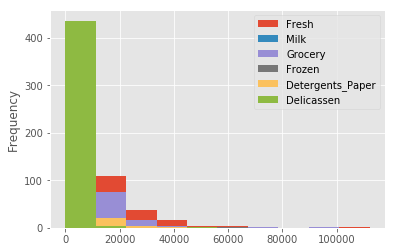

In [27]:
#
# TODO: Before unitizing / standardizing / normalizing your data in preparation for
# K-Means, it's a good idead to get a quick peek at it. You can do this using the 
# .describe() method, or even by using the built-in pandas df.plot.hist()
#
print(df.describe())
df.plot.hist()

In [31]:
#
# TODO: Having checked out your data, you may have noticed there's a pretty big gap
# between the top customers in each feature category and thee rest. Some feature
# scalling algo won't get rid of outliers for you, so it's a good idea to handle that
# manually---particularly if your data is NOT to determine the top customers. After
# all, you can do that with a simple Pandas .sort_values() and not a machine learning
# clustering algorithm. From a business perspective, you're probably more interested
# in clustering your +:- 2 standards deviation customers, rather than the creme delta
# creme, or botton of the barrel'ers
#
# Remove top 5 and bottom 5 samples for each column:
drop = {}
for col in df.columns:
    # Bottom 5
    sort = df.sort_values(by=col, ascending=True)
    if len(sort) > 5: sort=sort[:5]
    for index in sort.index: drop[index] = True # Just store the index one
    
    # Top 5:
    sort = df.sort_values(by=col, ascending=False)
    if len(sort) > 5: sort=sort[:5]
    for index in sort.index: drop[index] = True # Just store the index one

In [33]:
#
# INFO Drop rows by index. We do this all at once in case there is a
# collision. This way, we don't end up dropping more rows than we have
# to, if there is a single row that satisfies the drop for multiple columns.
# Since there are 6 rows, if we end up dropping < 5*6*2 = 60 rows, that means
# there indeed were collisions.
print ("Dropping {0} Outliers...".format(len(drop)))
df.drop(inplace=True, labels=drop.keys(), axis=0)
print (df.describe())

Dropping 42 Outliers...
              Fresh          Milk       Grocery        Frozen  \
count    398.000000    398.000000    398.000000    398.000000   
mean   10996.231156   5144.090452   7091.711055   2639.721106   
std     9933.042596   5057.406574   6923.019293   2974.246906   
min       37.000000    258.000000    314.000000     47.000000   
25%     3324.500000   1571.250000   2155.500000    749.750000   
50%     8257.500000   3607.500000   4573.000000   1526.000000   
75%    15828.500000   6953.250000   9922.250000   3370.250000   
max    53205.000000  29892.000000  39694.000000  17866.000000   

       Detergents_Paper   Delicassen  
count        398.000000   398.000000  
mean        2562.974874  1278.736181  
std         3608.176776  1220.745297  
min           10.000000    11.000000  
25%          273.250000   409.500000  
50%          812.000000   946.500000  
75%         3841.500000  1752.250000  
max        19410.000000  7844.000000  


In [34]:
#
# INFO: What are you interested in?
#
# Depending on what you're interested in, you might take a different approach
# to normalizing/standardizing your data.
# 
# You should note that all columns left in the dataset are of the same unit.
# You might ask yourself, do I even need to normalize / standardize the data?
# The answer depends on what you're trying to accomplish. For instance, although
# all the units are the same (generic money unit), the price per item in your
# store isn't. There may be some cheap items and some expensive one. If your goal
# is to find out what items people buy tend to buy together but you didn't 
# unitize properly before running kMeans, the contribution of the lesser priced
# item would be dwarfed by the more expensive item.
#
# For a great overview on a few of the normalization methods supported in SKLearn,
# please check out: https://stackoverflow.com/questions/30918781/right-function-for-normalizing-input-of-sklearn-svm
#
# Suffice to say, at the end of the day, you're going to have to know what question
# you want answered and what data you have available in order to select the best
# method for your purpose. Luckily, SKLearn's interfaces are easy to switch out
# so in the mean time, you can experiment with all of them and see how they alter
# your results.
#
#
# 5-sec summary before you dive deeper online:
#
# NORMALIZATION: Let's say your user spend a LOT. Normalization divides each item by
#                the average overall amount of spending. Stated differently, your
#                new feature is = the contribution of overall spending going into
#                that particular item: $spent on feature / $overall spent by sample
#
# MINMAX:        What % in the overall range of $spent by all users on THIS particular
#                feature is the current sample's feature at? When you're dealing with
#                all the same units, this will produce a near face-value amount. Be
#                careful though: if you have even a single outlier, it can cause all
#                your data to get squashed up in lower percentages.
#                Imagine your buyers usually spend $100 on wholesale milk, but today
#                only spent $20. This is the relationship you're trying to capture 
#                with MinMax. NOTE: MinMax doesn't standardize (std. dev.); it only
#                normalizes / unitizes your feature, in the mathematical sense.
#                MinMax can be used as an alternative to zero mean, unit variance scaling.
#                [(sampleFeatureValue-min) / (max-min)] * (max-min) + min
#                Where min and max are for the overall feature values for all samples.

In [35]:
#
# TODO: Un-comment just ***ONE*** of lines at a time and see how alters your results
# Pay attention to the direction of the arrows, as well as their LENGTHS
T = preprocessing.StandardScaler().fit_transform(df)
#T = preprocessing.MinMaxScaler().fit_transform(df)
#T = preprocessing.MaxAbsScaler().fit_transform(df)
#T = preprocessing.Normalizer().fit_transform(df)
#T = df # No Change

In [40]:
#
# INFO: Sometimes people perform PCA before doing KMeans, so that KMeans only
# operates on the most meaningful features. In our case, there are so few features
# that doing PCA ahead of time isn't really necessary, and you can do KMeans in
# feature space. But keep in mind you have the option to transform your data to
# bring down its dimensionality. If you take that route, then your Clusters will
# already be in PCA-transformed feature space, and you won't have to project them
# again for visualization.


# Do KMeans
n_clusters = 3
centroids, labels = doKMeans(T, n_clusters)

In [42]:
#
# TODO: Print out your centroids. They're currently in feature-space, which
# is good. Print them out before you transform them into PCA space for viewing
#
print(centroids)


[[-0.26232459 -0.41632038 -0.43893222 -0.29733807 -0.38963897 -0.32590196]
 [-0.56995352  1.31744707  1.58541223 -0.33454978  1.59481374  0.27849802]
 [ 1.20725644 -0.12927099 -0.31707856  1.08169261 -0.45400669  0.59174102]]


In [43]:
# Do PCA *after* to visualize the results. Project the centroids as well as 
# the samples into the new 2D feature space for visualization purposes.
display_pca = doPCA(T)
T = display_pca.transform(T)
CC = display_pca.transform(centroids)

C:\Users\CongCuongPHAM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


Projected Features by importance:
 [(4.439422524289905, 'Grocery'), (4.3521532757037855, 'Detergents_Paper'), (4.209841269791215, 'Milk'), (2.94634030532376, 'Delicassen'), (2.6965214173655356, 'Fresh'), (2.6383798432550747, 'Frozen')]
     Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen  label
0    12669   9656     7561     214              2674        1338      0
1     7057   9810     9568    1762              3293        1776      0
2     6353   8808     7684    2405              3516        7844      2
3    13265   1196     4221    6404               507        1788      2
4    22615   5410     7198    3915              1777        5185      2
5     9413   8259     5126     666              1795        1451      0
6    12126   3199     6975     480              3140         545      0
7     7579   4956     9426    1669              3321        2566      0
8     5963   3648     6192     425              1716         750      0
9     6006  11093    18881    1159          

C:\Users\CongCuongPHAM\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


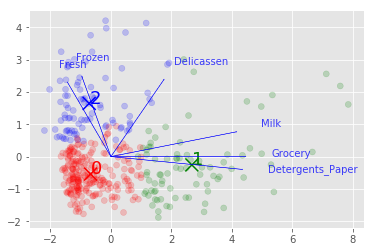

In [51]:
# Visualize all the samples. Give them the color of their cluster label
fig = plt.figure()
ax = fig.add_subplot(111)
if PLOT_TYPE_TEXT:
  # Plot the index of the sample, so you can further investigate it in your dset
  for i in range(len(T)): ax.text(T[i,0], T[i,1], df.index[i], color=c[labels[i]], alpha=0.75, zorder=600000)
  ax.set_xlim(min(T[:,0])*1.2, max(T[:,0])*1.2)
  ax.set_ylim(min(T[:,1])*1.2, max(T[:,1])*1.2)
else:
  # Plot a regular scatter plot
  sample_colors = [ c[labels[i]] for i in range(len(T)) ]
  ax.scatter(T[:, 0], T[:, 1], c=sample_colors, marker='o', alpha=0.2)


# Plot the Centroids as X's, and label them
ax.scatter(CC[:, 0], CC[:, 1], marker='x', s=169, linewidths=3, zorder=1000, c=c)
for i in range(len(centroids)): ax.text(CC[i, 0], CC[i, 1], str(i), zorder=500010, fontsize=18, color=c[i])


# Display feature vectors for investigation:
if PLOT_VECTORS: drawVectors(T, display_pca.components_, df.columns, plt)


# Add the cluster label back into the dataframe and display it:
df['label'] = pd.Series(labels, index=df.index)
print (df)

plt.show()